# Assignment - Week 4

Solving the 2D Laplace Equation [here](https://github.com/pasqal-io/eth_quantum_2024/blob/main/PASQAL_Challenge.pdf).

In [1]:
import torch
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(DEVICE)
print(f'Using device: {torch.get_default_device()}, dtype: {torch.get_default_dtype()}')

import qadence as qd
from qadence.draw import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk", palette="deep")
custom_palette = sns.color_palette(["#E63946", "#457B9D", "#2A9D8F", "#F4A261", "#E9C46A"])

%matplotlib inline

Using device: cuda:0, dtype: torch.float32


INFO  2025-01-13 23:51:32 - pyqtorch: PyQTorch logger successfully setup with log level 20


In [17]:
# must be equal for the time being
n_test_points = n_points = 50

xmin = ymin = 0.0
xmax = ymax = 0.9

# Prepare training data as a flattened grid
# (x0,y0), (x1,y0), ..., (x_n-1,y0), (x0, y1) ...

# shape: (n^2, 2)
inputs = torch.stack(
    torch.meshgrid(
        torch.linspace(xmin, xmax, n_points, requires_grad=True),
        torch.linspace(ymin, ymax, n_points, requires_grad=True),
        indexing="xy",
    ),
    dim=-1,
).reshape(-1, 2)
# print(inputs, inputs.shape)

# Detached clones of inputs
# Used to create Dirichlet boundary grids
# shape: n^2, 2
inputs_0_y, inputs_x_0, inputs_X_y, inputs_x_Y = [
    inputs.clone().detach(),
    inputs.clone().detach(),
    inputs.clone().detach(),
    inputs.clone().detach(),
]

inputs_0_y[:, 0] = xmin
inputs_x_0[:, 1] = ymin
inputs_X_y[:, 0] = xmax
inputs_x_Y[:, 1] = ymax

# shape: 4 * n^2, 2 > represents all boundary inputs
# note same order to be used for boundary values: (0,y) (x,0) (X,y) (x,Y)
inputs_boundary = torch.cat((inputs_0_y, inputs_x_0, inputs_X_y, inputs_x_Y), dim=0)

# print(inputs_boundary, inputs_boundary.shape)

inputs_x, inputs_y = inputs[:, 0].detach(), inputs[:, 1].detach()

# shape: 4 * n**2 > represents all expected boundary values
# NOTE: to treat x,y=X,Y as x_eff, y_eff = 1, 1, we rescale sin frequency
boundary_values = torch.cat(
    (
        torch.sin(np.pi * inputs_y / (ymax - ymin)),                   # 0, y
        torch.zeros_like(inputs_x),                                    # x, 0
        np.exp(-np.pi) * torch.sin(np.pi * inputs_y / (ymax - ymin)),  # X, y
        torch.zeros_like(inputs_x),                                    # x, Y
    ),
    dim=0,
).unsqueeze(1)

# print(boundary_values, boundary_values.shape)

test_x = torch.linspace(xmin, xmax, n_test_points).detach()
test_y = torch.linspace(ymin, ymax, n_test_points).detach()
test_inputs = torch.stack(torch.meshgrid(test_x, test_y, indexing="xy", ), dim=-1,).reshape(-1, 2)

solution = torch.exp(-np.pi * test_inputs[:, 0]) * torch.sin(np.pi * test_inputs[:, 1] / (ymax - ymin))
solution_grid = solution.reshape(n_test_points, n_test_points)

# print(solution, solution.shape)

## Description
1. Seperate x and y Cheby tower feature maps over N/2 qubits each
2. two N/2 sized HEA blocks of depth[0] and single N sized HEA block
3. total magnetization cost fn
4. $X = Y = 1$ effectively in the equation, but $xmax = ymax = 0.9$ is used, so all function arguments must be rescaled by `1.0 / (ymax - ymin)` or `1.0 / (xmax - xmin)`
5. `lr = 0.01` gives best results
6. `mode = 'pinned'` uses standard MSE loss terms over Dirichlet boundary with `boundary_loss_weight` coefficient
   prefer (insig. bdry loss) `1e1.5 < 1e4` (overpowering)
7. `mode = 'hc'` uses hard constraint based model architecture that fixes values at constraints
   use exponential decay factor wrt distance from each
   $$
   \phi(x,y) = \sum_{\text{cyclic } i,j,k,l} c_{i} e^{-k d_{i}} (1 - e^{-k d_{j}}) (1 - e^{-k d_{k}}) (1 - e^{-k d_{l}}) + \mathcal{\hat{U}}_{\varphi,\boldsymbol{\theta}} \;\prod_i (1 - e^{-k d_{i}})
   $$
   for $i, j, k, l \in \{0, 1, 2, 3\}$ each corresponding to $\{x = 0\}, \{y = 0\}, \{x = X\}, \{y = Y\}$ resp.
   
   where $c_i = c(x,y)_{i}$ is the boundary value corresponding to the projection of $(x,y)$ on $i$-th boundary and $d_i = d(x,y)_{i}$ is the distance from $i$-th boundary of $(x,y)$.

In [18]:
def calc_second_derivatives(outputs):
    eps = 1e-8
    # First derivatives with respect to inputs
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Debug gradients
    # print(f'First derivatives range: [{grad.min():.3e}, {grad.max():.3e}]')

    ddf_dxx = torch.autograd.grad(
        grad[:, 0],
        inputs,
        grad_outputs=torch.ones_like(grad[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0][:, 0]
    
    ddf_dyy = torch.autograd.grad(
        grad[:, 1],
        inputs,
        grad_outputs=torch.ones_like(grad[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0][:, 1]

    # print(f'd²f/dx²: [{ddf_dxx.min():.3e}, {ddf_dxx.max():.3e}]    d²f/dy²: [{ddf_dyy.min():.3e}, {ddf_dyy.max():.3e}]')

    return ddf_dxx, ddf_dyy


def train_model(
    model: qd.QuantumModel, n_epochs, lr, loss_fn,
):

    # Add learning rate scheduling
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
    )

    # Initialize histories
    loss_hist, score_hist = [], []
    best_loss = float("inf")
    patience = 50
    patience_counter = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Compute loss with gradient clipping
        loss, score = loss_fn()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loss.backward()
        optimizer.step()
        
        print(f"[{epoch+1}] lr: {(scheduler.get_last_lr()[0]):.3e}")
        # Compute gradient norm
        # grad_norm = 0.0
        # for param in model.parameters():
        #     if param.grad is not None:
        #         grad_norm += param.grad.norm(2).detach().item() ** 2
        # grad_norm = grad_norm ** 0.5
        # print(f"grad norm: {grad_norm}")


        current_loss = loss.item()
        loss_hist.append(current_loss)
        score_hist.append(score)

        # Learning rate scheduling
        scheduler.step(current_loss)

        # Early stopping
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            pass

        print()

    return np.array(loss_hist), np.array(score_hist)

# Plot result
def plot_result(histories, f_xy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    f_xy_grid = f_xy.reshape(n_test_points, n_test_points)

    ax2.pcolormesh(test_x.cpu(), test_y.cpu(), f_xy_grid.cpu(), shading="auto", cmap="plasma")
    ax2.set_title(r"DQC solution $u(x,y)$")

    ax1.plot(np.arange(len(histories[0])), histories[0], label=r"${L}_F$")
    if len(histories) == 2:
        ax1.plot(np.arange(len(histories[1])), histories[1], label=r"${L}_Q$")
    ax1.set_yscale("log")

    ax1.grid(True)
    ax2.grid(True)

    ax1.set_xlabel(r"$n_j$")
    ax1.set_ylabel("loss")

    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$y$")
    
    ax1.legend()

    fig.tight_layout()
    # plt.show()


def get_qnn_model(n_qubits: int, depth: list[int], cost_obs: qd.AbstractBlock):
    fm_x = qd.feature_map(
        n_qubits=n_qubits // 2,
        support=range(0, n_qubits // 2),
        param="x",
        fm_type=qd.BasisSet.CHEBYSHEV,
        op=qd.RY,
        reupload_scaling=qd.ReuploadScaling.TOWER,
    )

    fm_y = qd.feature_map(
        n_qubits=n_qubits // 2,
        support=range(n_qubits // 2, n_qubits),
        param="y",
        fm_type=qd.BasisSet.CHEBYSHEV,
        op=qd.RY,
        reupload_scaling=qd.ReuploadScaling.TOWER,
    )

    # Add entangling layers between coordinate encodings
    # entangling_layer_x = qd.chain(qd.CNOT(i, (i+1) % (n_qubits // 2)) for i in range(n_qubits // 2))
    # entangling_layer_y = qd.chain(qd.CNOT(i + n_qubits // 2, ((i+1) % (n_qubits // 2)) + n_qubits // 2) for i in range(n_qubits // 2))
    # entangling_layer = qd.chain(qd.CNOT(i, (i+1) % n_qubits) for i in range(n_qubits))
    # entangling_layer = qd.kron(entangling_layer_x, entangling_layer_y)
    
    fm = qd.kron(fm_x, fm_y)
    # fm = qd.chain(fm, entangling_layer)
    
    ansatz1_x = qd.hea(
        n_qubits=n_qubits // 2,
        support=range(0, n_qubits // 2),
        depth=depth[0],
        operations=[qd.RY, qd.RZ],
        entangler=qd.CNOT,
    )

    ansatz1_y = qd.hea(
        n_qubits=n_qubits // 2,
        support=range(n_qubits // 2, n_qubits),
        depth=depth[0],
        operations=[qd.RY, qd.RZ],
        entangler=qd.CNOT,
    )
    ansatz1 = qd.kron(ansatz1_x, ansatz1_y)

    ansatz2 = qd.hea(
        n_qubits=n_qubits,
        depth=depth[1],
        operations=[qd.RY, qd.RZ],
        entangler=qd.CNOT,
    )

    # circuit structure:
    # seperate x and y feature maps,
    # with seperate ansatzes = ansatz1,
    # followed by a common shallow ansatz = ansatz2 
    
    circuit = qd.QuantumCircuit(n_qubits, qd.chain(fm, ansatz1, ansatz2))
    model = qd.QNN(circuit=circuit, observable=cost_obs, inputs=["x", "y"])
    
    # Initialize parameters in range [0, 2pi/50)
    model.reset_vparams(torch.rand(model.num_vparams).unsqueeze(1) * 2 * torch.pi / 50)
    
    return [model]


# calculate for hard constraint (hc) type trial function

# c[i][j] = boundary val at i-th boundary of j-th grid point
c = boundary_values.reshape(4, -1)

# d[i][j] = distance from i-th boundary of j-th grid point
d = torch.stack((inputs_x - xmin, inputs_y - ymin, xmax - inputs_x, ymax - inputs_y), dim = 0)

# `rot_d` consists of `d` rotated by 0, 1, 2, 3 indices along dim = 0 respectively
# so that `hc_trial_fn` calculation can be sped up
rot_d = torch.stack(tuple(torch.roll(d, shifts=-i, dims=0) for i in range(4)), dim=0)

# placeholders; real values are set as global before training
k = 1

# sum(c0 * e^-kd0 * (1-e^-kd1) * (1-e^-kd2) * (1-e^-kd3)) + MLP(x) * (1-e^-kd0) * (1-e^-kd1) * (1-e^-kd2) * (1-e^-kd3)
def hc_trial_fn(outputs):
    global c, rot_d
    
    rot_e = torch.exp(-k * rot_d)
    e = rot_e[0]
    f_xy = torch.sum(c * rot_e[0] * (1 - rot_e[1]) * (1 - rot_e[2]) * (1 - rot_e[3]), dim = 0)
    f_xy += outputs.squeeze() * torch.prod(1 - e, dim = 0)
    
    return f_xy
    

# General subroutine for loss function
def create_loss_fn(model: torch.nn.Module, mode: str, boundary_loss_weight: float = 0):
    
    # loss fn based on using hard constraints for trial fn
    # such trial fn always satisfies bdry condns
    # hence loss fn is purely differential residual term
    def hc_loss_fn() -> torch.Tensor:
        eps = 1e-8

        outputs = model(inputs)
        # using fixed boundary handling suggested in:
        # https://arxiv.org/pdf/2212.07462, p5
        # ϕhPINN = c*exp(−kd(x)) + (1 − exp(−kd(x)))MLP(x; θ)
        # for given case, we use:
        # sum(c0 * e^-kd0 * (1-e^-kd1) * (1-e^-kd2) * (1-e^-kd3)) + MLP(x) * (1-e^-kd0) * (1-e^-kd1) * (1-e^-kd2) * (1-e^-kd3)
        f_xy = hc_trial_fn(outputs)
            
        ddf_dxx, ddf_dyy = calc_second_derivatives(f_xy)
        
        # physics informed loss function -> expectation of square of laplacian
        diff_loss = torch.mean((ddf_dxx + ddf_dyy) ** 2)
        
        score = torch.nn.MSELoss()(u_xy, f_xy).detach().item()

        print(f"diff_loss = {diff_loss:.3e}, score = {score:.3e}")

        return diff_loss, score
    
    # pinned boundary handling based loss fn
    def pinned_loss_fn(_boundary_loss_weight: float = boundary_loss_weight,) -> torch.Tensor:
        global inputs, inputs_boundary, boundary_values
        eps = 1e-8

        f_xy = model(inputs)

        ddf_dxx, ddf_dyy = calc_second_derivatives(f_xy)

        diff_loss = torch.mean((ddf_dxx + ddf_dyy) ** 2)

        # Compute boundary loss
        boundary_pred = model(inputs_boundary)
        wgtd_bdry_loss = _boundary_loss_weight * torch.nn.MSELoss()(boundary_pred, boundary_values)

        score = torch.nn.MSELoss()(u_xy, f_xy).detach().item()
        
        print(f"diff_loss = {diff_loss:.3e}, wgtd_bdry_loss = {wgtd_bdry_loss:.3e}, score = {score:.3e}")

        total_loss = diff_loss + wgtd_bdry_loss

        return total_loss, score

    if mode == 'pinned':
        return pinned_loss_fn
    if mode == 'hc':
        return hc_loss_fn

## Learnings

1. atleast 500 epochs needed for acceptable soln
2. **`hc` with `k = 1.5` gives an initial state very very close to actual solution hence a good choice**
3. `hc` is much faster than `pinned`, especially when utilizing CUDA cores
4. *cuda cores help only when for sufficiently large parameter set like N > 6, d > 5; `pinned` does NOT help in this regard*
5. inc $d_2$ has negligible impact on convergence (as expected since features are seperable)
6. inc $d_1$ has significant impact on convergence (as expected ...)
7. $N=8$ is not worth it. much slower to train both per iteration and total iterations needed to converge
   
   also the features are probably not complex enough to require 4 qubits each
8. *hard to get a score <0.05 in 500 epochs*
9.  increasing points will increase training time drastically and negatively impact optimization

- having a CUDA-enabled GPU does come in handy :) 

/home/hades/MnP_CPP_2024/intro_to_qml/torch-cuda-venv/lib/python3.10/site-packages/torch/utils/_device.py:79: UserWarning: Using a target size (torch.Size([2500, 1])) that is different to the input size (torch.Size([2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


(hc) score: 0.07733521830717593
(pinned) score: 2.0526739560454126


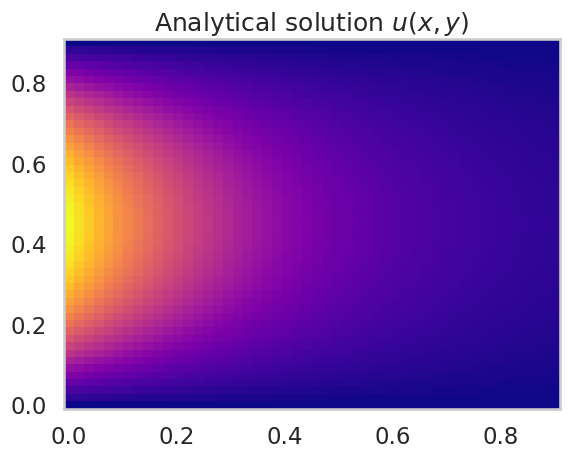

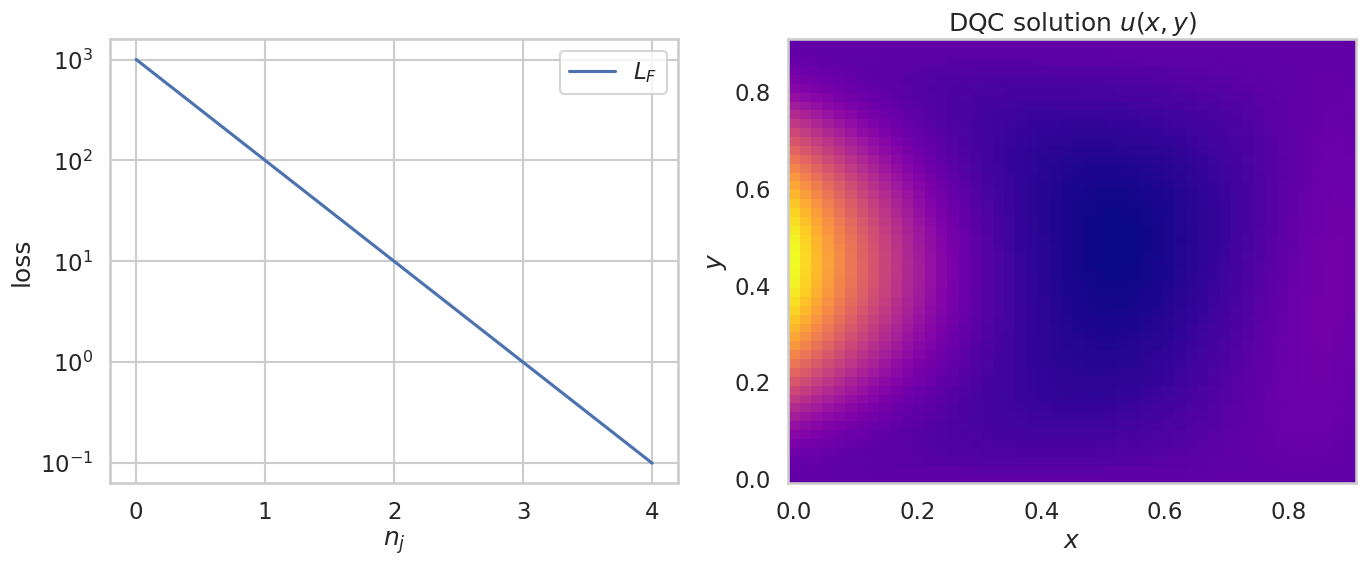

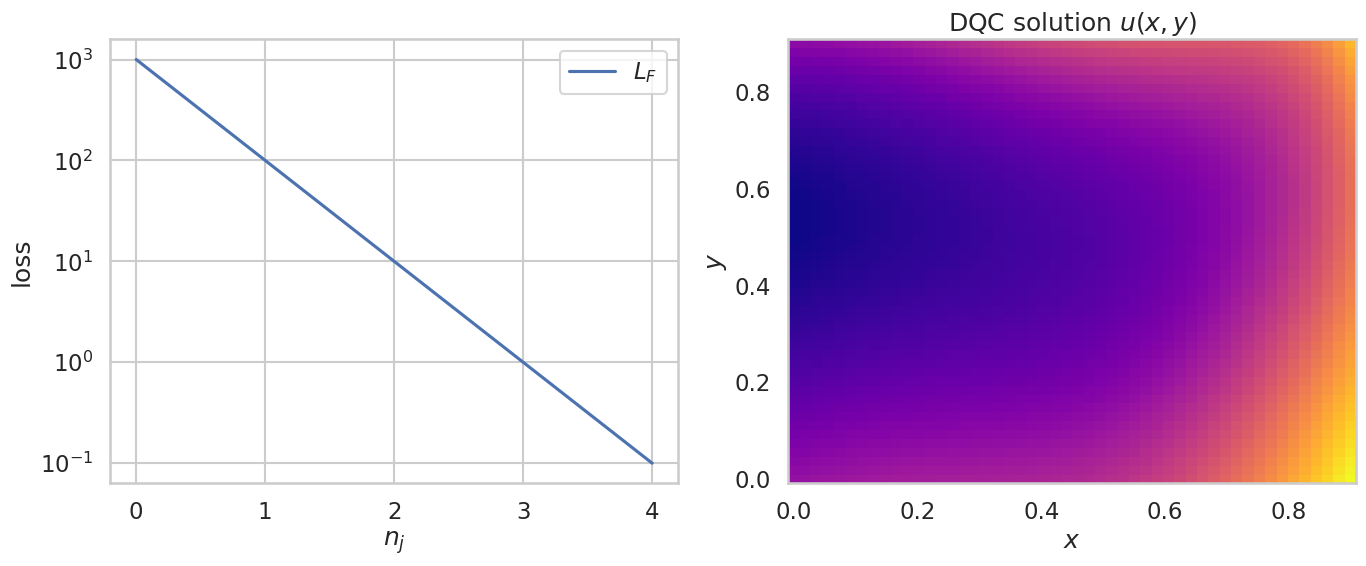

In [19]:
# TEST RUN

torch.manual_seed(4)

n_qubits = 6
depth = [5, 1]

# total magnetization
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
mode = 'hc'
n_epochs = 1000
lr = 0.01
boundary_loss_weight = 1e3

k = 1.5

f_xy_hc = hc_trial_fn(get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)[0](test_inputs)).detach()

f_xy_pinned = (get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)[0](test_inputs)).detach()

u_xy = solution
score_hc = torch.nn.MSELoss()(u_xy, f_xy_hc).item()
score_pinned = torch.nn.MSELoss()(u_xy, f_xy_pinned).item()
print(f"(hc) score:", score_hc)
print(f"(pinned) score:", score_pinned)

# plotting true solution
plt.pcolormesh(test_x.cpu(), test_y.cpu(), solution_grid.cpu(), shading='auto', cmap='plasma')
plt.title(r'Analytical solution $u(x,y)$')

# dummy values
plot_result([np.array([1e3, 1e2, 1e1, 1e0, 1e-1])], f_xy_hc);
plot_result([np.array([1e3, 1e2, 1e1, 1e0, 1e-1])], f_xy_pinned);


diff_loss = 2.378e-02, score = 8.047e-02
[1] lr: 1.000e-02

diff_loss = 2.013e-02, score = 8.035e-02
[2] lr: 1.000e-02

diff_loss = 1.680e-02, score = 8.021e-02
[3] lr: 1.000e-02

diff_loss = 1.384e-02, score = 8.007e-02
[4] lr: 1.000e-02

diff_loss = 1.126e-02, score = 7.992e-02
[5] lr: 1.000e-02

diff_loss = 9.097e-03, score = 7.976e-02
[6] lr: 1.000e-02

diff_loss = 7.348e-03, score = 7.959e-02
[7] lr: 1.000e-02

diff_loss = 6.008e-03, score = 7.943e-02
[8] lr: 1.000e-02

diff_loss = 5.055e-03, score = 7.926e-02
[9] lr: 1.000e-02

diff_loss = 4.451e-03, score = 7.910e-02
[10] lr: 1.000e-02

diff_loss = 4.138e-03, score = 7.896e-02
[11] lr: 1.000e-02

diff_loss = 4.041e-03, score = 7.884e-02
[12] lr: 1.000e-02

diff_loss = 4.078e-03, score = 7.876e-02
[13] lr: 1.000e-02

diff_loss = 4.177e-03, score = 7.870e-02
[14] lr: 1.000e-02

diff_loss = 4.279e-03, score = 7.867e-02
[15] lr: 1.000e-02

diff_loss = 4.347e-03, score = 7.867e-02
[16] lr: 1.000e-02

diff_loss = 4.362e-03, score = 7.

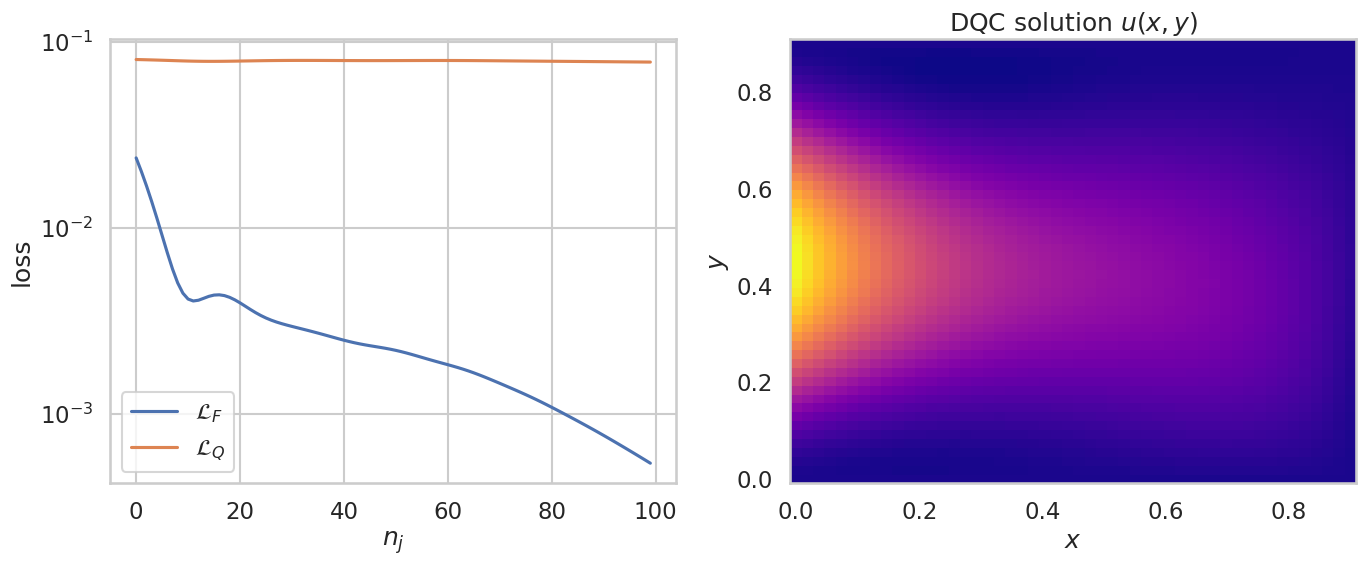

In [141]:
# QUICK TEST: N = 6, D = [5, 1], epochs = 100, mode = hc, k = 1, score = 0.078, time = 2.5m

n_qubits = 6
depth = [5, 1]
n_epochs = 100
mode = 'hc'
k = 1
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

## Comparison
For epochs = 500, mode = hc, n_points = 50

| Label | $N$ | $d_1$ | $d_2$ | $k$ | Score | Loss | Time | Remark
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| control   | 6 | 6 | 1 | 1.5 | 0.057 | 4e-5 | 24m | reference |
| dec $k$   | 6 | 6 | 1 | 1.0 | 0.074 | 3e-6 | 15m | better training but worse starting point so worse soln |
| inc $N$   | 8 | 6 | 1 | 1.5 | 0.057 | 4e-5 | 80m | not worth extra computn |
| inc $d2$  | 6 | 6 | 4 | 1.5 | 0.062 | 5e-5 | 19m | dont help a lot |
| inc $d1$  | 6 | 9 | 1 | 1.5 | 0.061 | 3e-5 | 20m | helps! **FASTEST CONVERGENCE** |

diff_loss = 3.307e-01, score = 5.410e-02
[1] lr: 1.000e-02

diff_loss = 2.912e-01, score = 5.456e-02
[2] lr: 1.000e-02

diff_loss = 2.521e-01, score = 5.503e-02
[3] lr: 1.000e-02

diff_loss = 2.145e-01, score = 5.552e-02
[4] lr: 1.000e-02

diff_loss = 1.792e-01, score = 5.603e-02
[5] lr: 1.000e-02

diff_loss = 1.471e-01, score = 5.654e-02
[6] lr: 1.000e-02

diff_loss = 1.192e-01, score = 5.705e-02
[7] lr: 1.000e-02

diff_loss = 9.627e-02, score = 5.756e-02
[8] lr: 1.000e-02

diff_loss = 7.875e-02, score = 5.805e-02
[9] lr: 1.000e-02

diff_loss = 6.676e-02, score = 5.849e-02
[10] lr: 1.000e-02

diff_loss = 5.976e-02, score = 5.884e-02
[11] lr: 1.000e-02

diff_loss = 5.665e-02, score = 5.907e-02
[12] lr: 1.000e-02

diff_loss = 5.599e-02, score = 5.919e-02
[13] lr: 1.000e-02

diff_loss = 5.625e-02, score = 5.920e-02
[14] lr: 1.000e-02

diff_loss = 5.619e-02, score = 5.911e-02
[15] lr: 1.000e-02

diff_loss = 5.498e-02, score = 5.893e-02
[16] lr: 1.000e-02

diff_loss = 5.234e-02, score = 5.

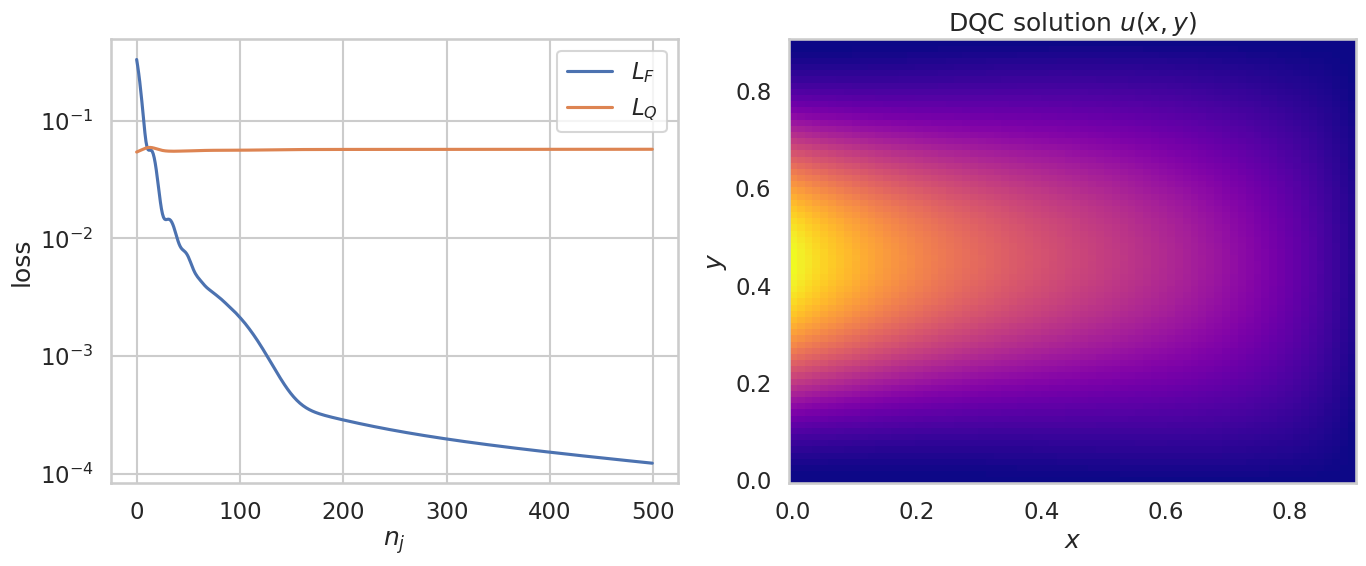

In [ ]:
# [using 72 pts] N = 6, D = [6, 1], epochs = 500, mode = hc, k = 1.5, score = 0.057, time = 32m
# poorer optimization and slower convergence

n_qubits = 6
depth = [6, 1]
n_epochs = 500
mode = 'hc'
k = 1.5
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 3.709e-01, score = 5.362e-02
[1] lr: 1.000e-02

diff_loss = 3.353e-01, score = 5.390e-02
[2] lr: 1.000e-02

diff_loss = 2.990e-01, score = 5.420e-02
[3] lr: 1.000e-02

diff_loss = 2.629e-01, score = 5.449e-02
[4] lr: 1.000e-02

diff_loss = 2.274e-01, score = 5.479e-02
[5] lr: 1.000e-02

diff_loss = 1.933e-01, score = 5.510e-02
[6] lr: 1.000e-02

diff_loss = 1.613e-01, score = 5.541e-02
[7] lr: 1.000e-02

diff_loss = 1.319e-01, score = 5.573e-02
[8] lr: 1.000e-02

diff_loss = 1.059e-01, score = 5.605e-02
[9] lr: 1.000e-02

diff_loss = 8.397e-02, score = 5.638e-02
[10] lr: 1.000e-02

diff_loss = 6.645e-02, score = 5.671e-02
[11] lr: 1.000e-02

diff_loss = 5.361e-02, score = 5.704e-02
[12] lr: 1.000e-02

diff_loss = 4.533e-02, score = 5.734e-02
[13] lr: 1.000e-02

diff_loss = 4.109e-02, score = 5.761e-02
[14] lr: 1.000e-02

diff_loss = 3.997e-02, score = 5.782e-02
[15] lr: 1.000e-02

diff_loss = 4.072e-02, score = 5.796e-02
[16] lr: 1.000e-02

diff_loss = 4.211e-02, score = 5.

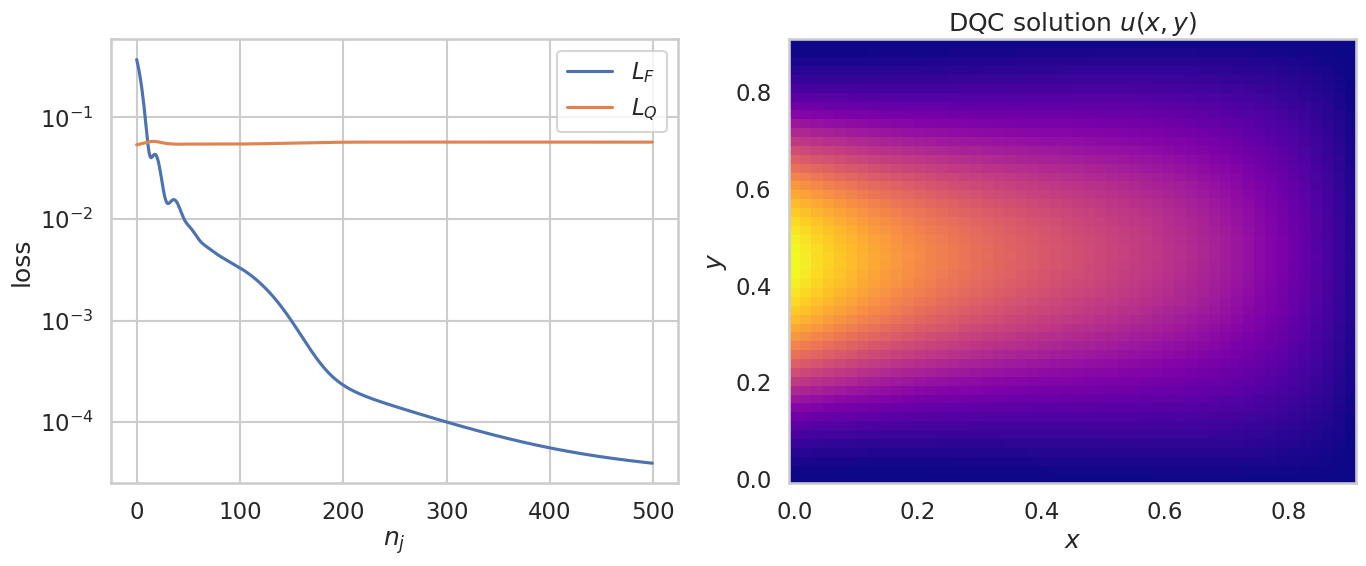

In [ ]:
# N = 6, D = [6, 1], epochs = 500, mode = hc, k = 1.5, score = 0.057, time = 24m

n_qubits = 6
depth = [6, 1]
n_epochs = 500
mode = 'hc'
k = 1.5
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 3.323e-02, score = 7.292e-02
[1] lr: 1.000e-02

diff_loss = 3.018e-02, score = 7.305e-02
[2] lr: 1.000e-02

diff_loss = 2.705e-02, score = 7.319e-02
[3] lr: 1.000e-02

diff_loss = 2.390e-02, score = 7.334e-02
[4] lr: 1.000e-02

diff_loss = 2.079e-02, score = 7.350e-02
[5] lr: 1.000e-02

diff_loss = 1.779e-02, score = 7.367e-02
[6] lr: 1.000e-02

diff_loss = 1.498e-02, score = 7.384e-02
[7] lr: 1.000e-02

diff_loss = 1.243e-02, score = 7.402e-02
[8] lr: 1.000e-02



diff_loss = 1.021e-02, score = 7.420e-02
[9] lr: 1.000e-02

diff_loss = 8.371e-03, score = 7.437e-02
[10] lr: 1.000e-02

diff_loss = 6.961e-03, score = 7.455e-02
[11] lr: 1.000e-02

diff_loss = 5.986e-03, score = 7.471e-02
[12] lr: 1.000e-02

diff_loss = 5.415e-03, score = 7.485e-02
[13] lr: 1.000e-02

diff_loss = 5.167e-03, score = 7.497e-02
[14] lr: 1.000e-02

diff_loss = 5.126e-03, score = 7.504e-02
[15] lr: 1.000e-02

diff_loss = 5.168e-03, score = 7.508e-02
[16] lr: 1.000e-02

diff_loss = 5.189e-03, score = 7.507e-02
[17] lr: 1.000e-02

diff_loss = 5.122e-03, score = 7.503e-02
[18] lr: 1.000e-02

diff_loss = 4.938e-03, score = 7.497e-02
[19] lr: 1.000e-02

diff_loss = 4.638e-03, score = 7.488e-02
[20] lr: 1.000e-02

diff_loss = 4.246e-03, score = 7.477e-02
[21] lr: 1.000e-02

diff_loss = 3.796e-03, score = 7.465e-02
[22] lr: 1.000e-02

diff_loss = 3.324e-03, score = 7.453e-02
[23] lr: 1.000e-02

diff_loss = 2.866e-03, score = 7.440e-02
[24] lr: 1.000e-02

diff_loss = 2.449e-03, sc

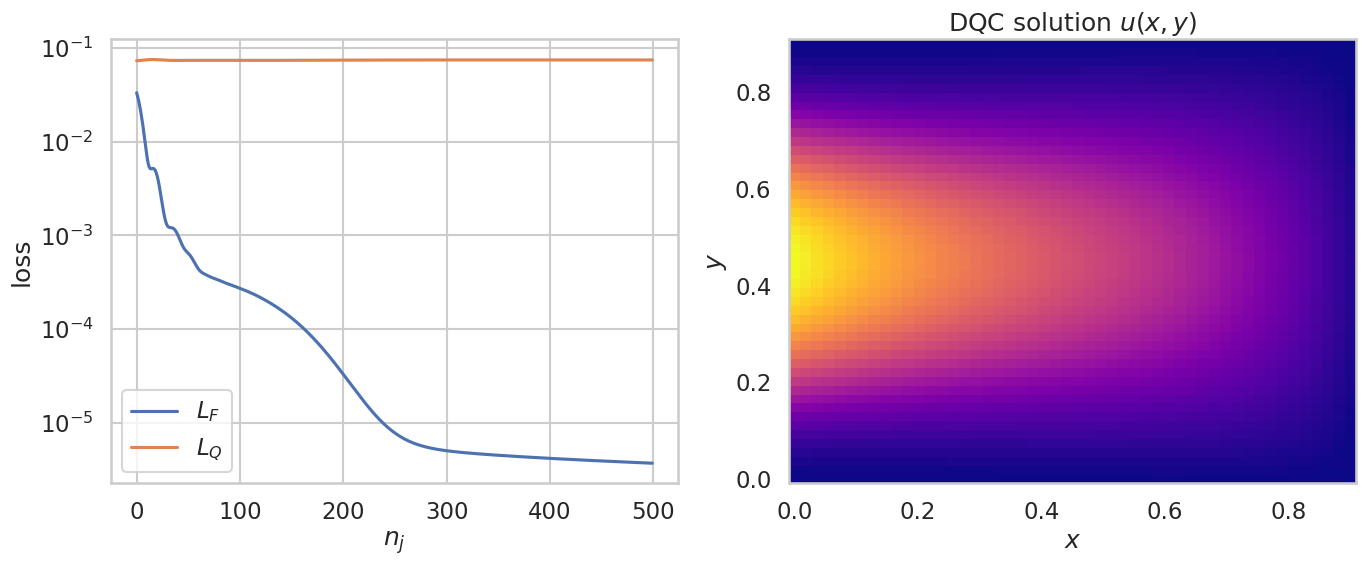

In [ ]:
# N = 6, D = [6, 1], epochs = 500, mode = hc, k = 1, score = .074, time = 15m

n_qubits = 6
depth = [6, 1]
n_epochs = 500
mode = 'hc'
k = 1
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 8.085e-01, score = 5.690e-02
[1] lr: 1.000e-03

diff_loss = 7.946e-01, score = 5.696e-02
[2] lr: 1.000e-03

diff_loss = 7.809e-01, score = 5.701e-02
[3] lr: 1.000e-03

diff_loss = 7.673e-01, score = 5.707e-02
[4] lr: 1.000e-03

diff_loss = 7.539e-01, score = 5.713e-02
[5] lr: 1.000e-03

diff_loss = 7.407e-01, score = 5.719e-02
[6] lr: 1.000e-03

diff_loss = 7.276e-01, score = 5.724e-02
[7] lr: 1.000e-03

diff_loss = 7.148e-01, score = 5.730e-02
[8] lr: 1.000e-03

diff_loss = 7.021e-01, score = 5.736e-02
[9] lr: 1.000e-03

diff_loss = 6.896e-01, score = 5.741e-02
[10] lr: 1.000e-03

diff_loss = 6.772e-01, score = 5.747e-02
[11] lr: 1.000e-03

diff_loss = 6.650e-01, score = 5.752e-02
[12] lr: 1.000e-03

diff_loss = 6.530e-01, score = 5.758e-02
[13] lr: 1.000e-03

diff_loss = 6.412e-01, score = 5.763e-02
[14] lr: 1.000e-03

diff_loss = 6.295e-01, score = 5.769e-02
[15] lr: 1.000e-03

diff_loss = 6.180e-01, score = 5.774e-02
[16] lr: 1.000e-03

diff_loss = 6.066e-01, score = 5.

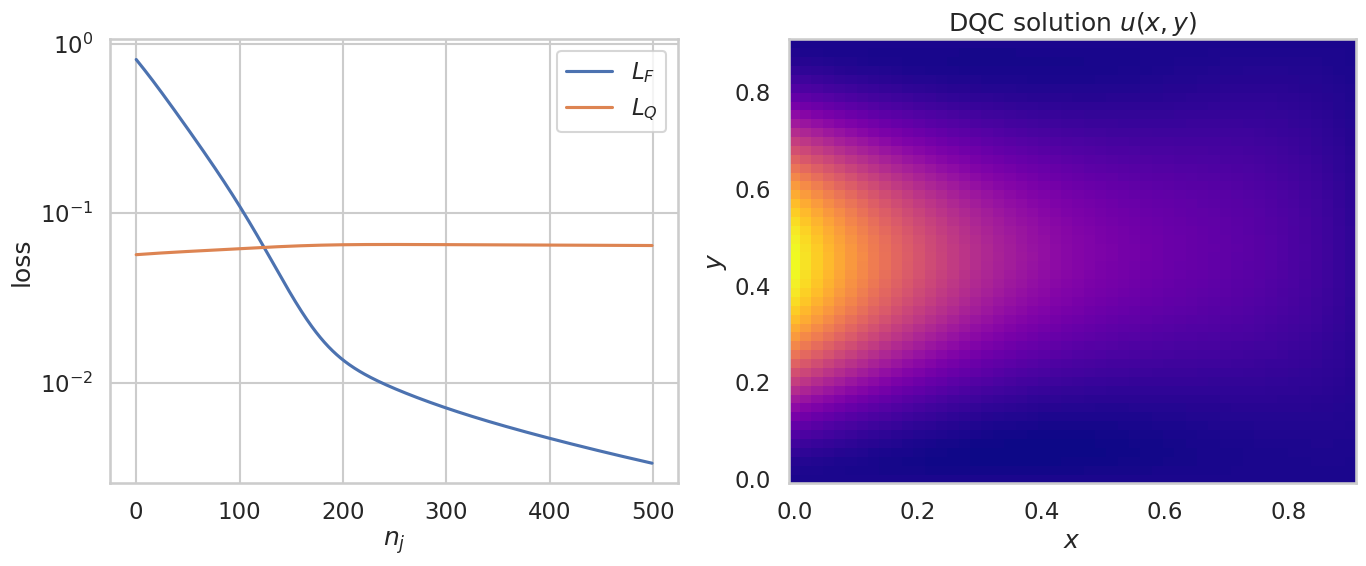

In [11]:
# N = 8, D = [6, 1], epochs = 500, mode = hc, k = 1.5, score = ..., time = 80m

n_qubits = 8
depth = [6, 1]
n_epochs = 500
mode = 'hc'
k = 1.5
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.001

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=0,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 9.235e-02, score = 6.564e-02
[1] lr: 1.000e-02

diff_loss = 7.226e-02, score = 6.586e-02
[2] lr: 1.000e-02

diff_loss = 5.687e-02, score = 6.604e-02
[3] lr: 1.000e-02

diff_loss = 4.575e-02, score = 6.616e-02
[4] lr: 1.000e-02

diff_loss = 3.832e-02, score = 6.625e-02
[5] lr: 1.000e-02

diff_loss = 3.379e-02, score = 6.636e-02
[6] lr: 1.000e-02

diff_loss = 3.122e-02, score = 6.650e-02
[7] lr: 1.000e-02

diff_loss = 2.961e-02, score = 6.666e-02
[8] lr: 1.000e-02

diff_loss = 2.818e-02, score = 6.684e-02
[9] lr: 1.000e-02

diff_loss = 2.645e-02, score = 6.700e-02
[10] lr: 1.000e-02

diff_loss = 2.429e-02, score = 6.714e-02
[11] lr: 1.000e-02

diff_loss = 2.184e-02, score = 6.726e-02
[12] lr: 1.000e-02

diff_loss = 1.934e-02, score = 6.734e-02
[13] lr: 1.000e-02

diff_loss = 1.705e-02, score = 6.738e-02
[14] lr: 1.000e-02

diff_loss = 1.516e-02, score = 6.738e-02
[15] lr: 1.000e-02

diff_loss = 1.374e-02, score = 6.732e-02
[16] lr: 1.000e-02

diff_loss = 1.274e-02, score = 6.

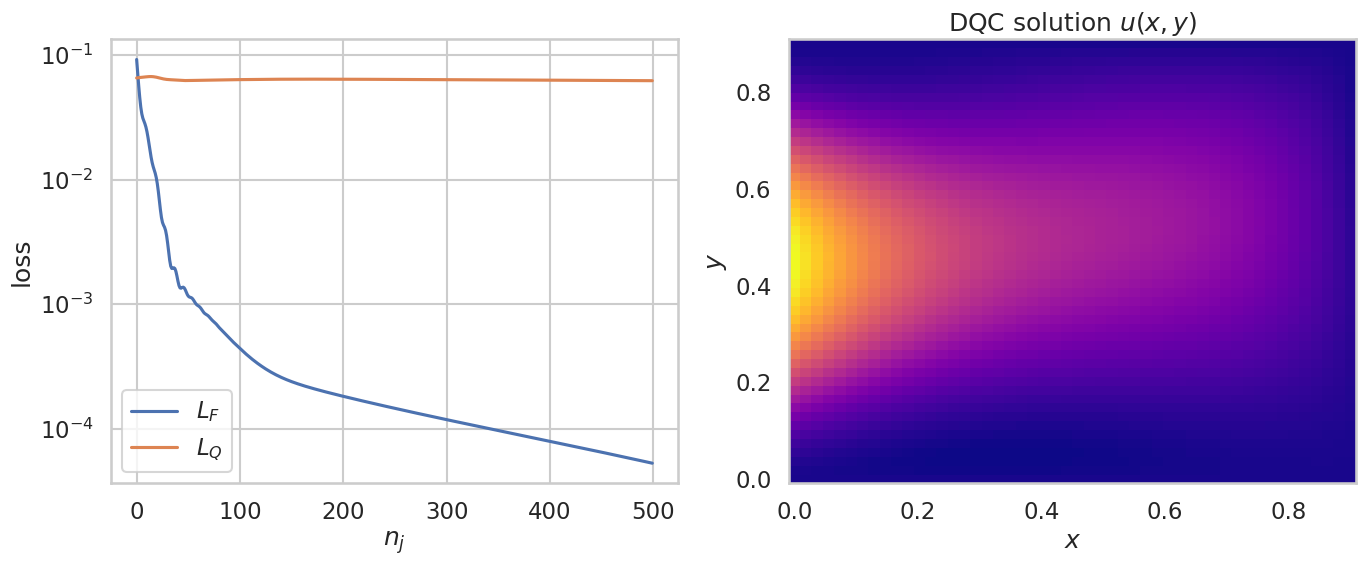

In [7]:
# N = 6, D = [6, 4], epochs = 500, mode = hc, k = 1.5, score = 0.062, time = 20m

n_qubits = 6
depth = [6, 4]
n_epochs = 500
mode = 'hc'
k = 1.5
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 2.359e-01, score = 7.689e-02
[1] lr: 1.000e-02

diff_loss = 1.678e-01, score = 7.588e-02
[2] lr: 1.000e-02

diff_loss = 1.126e-01, score = 7.476e-02
[3] lr: 1.000e-02

diff_loss = 7.220e-02, score = 7.357e-02
[4] lr: 1.000e-02

diff_loss = 4.732e-02, score = 7.235e-02
[5] lr: 1.000e-02

diff_loss = 3.705e-02, score = 7.115e-02
[6] lr: 1.000e-02

diff_loss = 3.842e-02, score = 7.004e-02
[7] lr: 1.000e-02

diff_loss = 4.645e-02, score = 6.913e-02
[8] lr: 1.000e-02

diff_loss = 5.536e-02, score = 6.852e-02
[9] lr: 1.000e-02

diff_loss = 6.091e-02, score = 6.823e-02
[10] lr: 1.000e-02

diff_loss = 6.157e-02, score = 6.822e-02
[11] lr: 1.000e-02

diff_loss = 5.794e-02, score = 6.842e-02
[12] lr: 1.000e-02

diff_loss = 5.162e-02, score = 6.876e-02
[13] lr: 1.000e-02

diff_loss = 4.432e-02, score = 6.919e-02
[14] lr: 1.000e-02

diff_loss = 3.745e-02, score = 6.966e-02
[15] lr: 1.000e-02

diff_loss = 3.195e-02, score = 7.011e-02
[16] lr: 1.000e-02

diff_loss = 2.823e-02, score = 7.

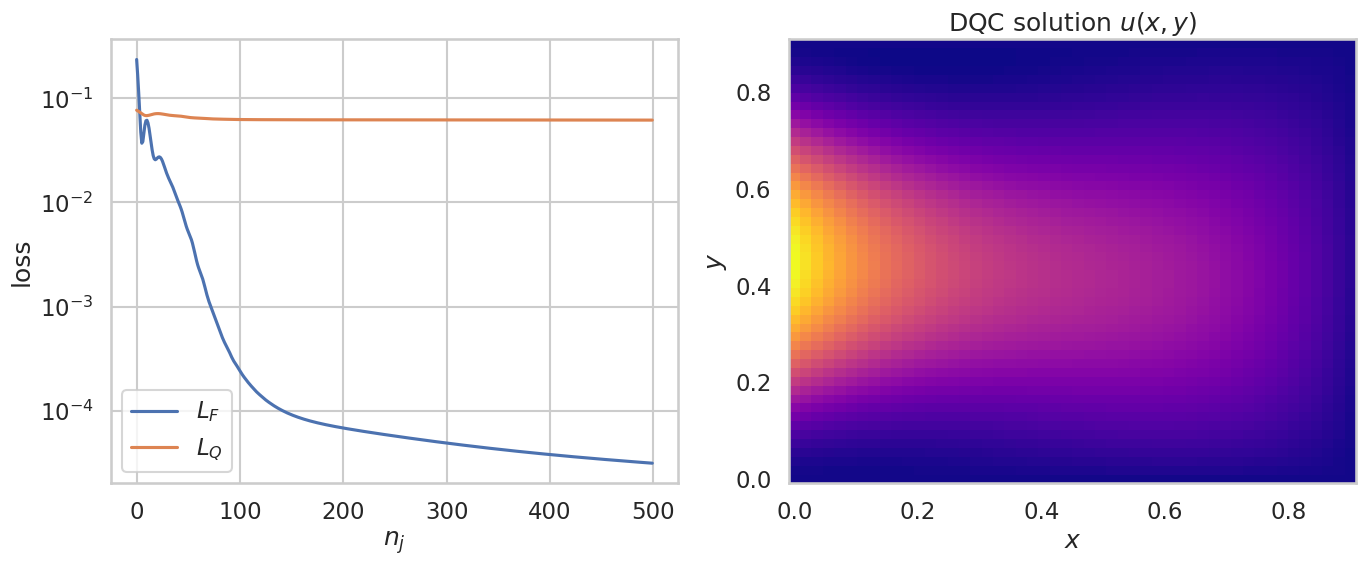

In [8]:
# [BEST] N = 6, D = [9, 1], epochs = 500, mode = hc, k = 1.5, score = 0.061, time = 20m

n_qubits = 6
depth = [9, 1]
n_epochs = 500
mode = 'hc'
k = 1.5
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

### Note on `pinned` vs `hc`

Some tests with `pinned` boundary handling mode. Worse results but worth comparing to learn advantage of hqPINN design
1. assuming that circuit evaluation over the training grid can be done in $n$ GPU cycles (small $n$):
   
   in `pinned` case, additional evaluations will be required so per itern time inc. a significant factor
   
   (*note i tried reusing boundary values obtained from total training grid by slicing, but that introduces complex dependencies that are hard to optimize*)

2. balancing bdry loss with PDE loss is hard since it varies over iteration cycles; one may need different learning rate for both losses, and/or iteration-step dependent bdry loss weight

/home/hades/MnP_CPP_2024/intro_to_qml/torch-cuda-venv/lib/python3.10/site-packages/torch/utils/_device.py:79: UserWarning: Using a target size (torch.Size([2500, 1])) that is different to the input size (torch.Size([2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


diff_loss = 7.709e+02, wgtd_bdry_loss = 1.681e+02, score = 2.063e+00
[1] lr: 1.000e-02

diff_loss = 7.093e+02, wgtd_bdry_loss = 1.749e+02, score = 2.131e+00
[2] lr: 1.000e-02

diff_loss = 6.476e+02, wgtd_bdry_loss = 1.807e+02, score = 2.182e+00
[3] lr: 1.000e-02

diff_loss = 5.874e+02, wgtd_bdry_loss = 1.846e+02, score = 2.211e+00
[4] lr: 1.000e-02

diff_loss = 5.289e+02, wgtd_bdry_loss = 1.871e+02, score = 2.224e+00
[5] lr: 1.000e-02

diff_loss = 4.727e+02, wgtd_bdry_loss = 1.888e+02, score = 2.222e+00
[6] lr: 1.000e-02

diff_loss = 4.197e+02, wgtd_bdry_loss = 1.895e+02, score = 2.208e+00
[7] lr: 1.000e-02

diff_loss = 3.707e+02, wgtd_bdry_loss = 1.894e+02, score = 2.182e+00
[8] lr: 1.000e-02

diff_loss = 3.261e+02, wgtd_bdry_loss = 1.883e+02, score = 2.146e+00
[9] lr: 1.000e-02

diff_loss = 2.863e+02, wgtd_bdry_loss = 1.863e+02, score = 2.098e+00
[10] lr: 1.000e-02

diff_loss = 2.513e+02, wgtd_bdry_loss = 1.832e+02, score = 2.040e+00
[11] lr: 1.000e-02

diff_loss = 2.210e+02, wgtd_bd

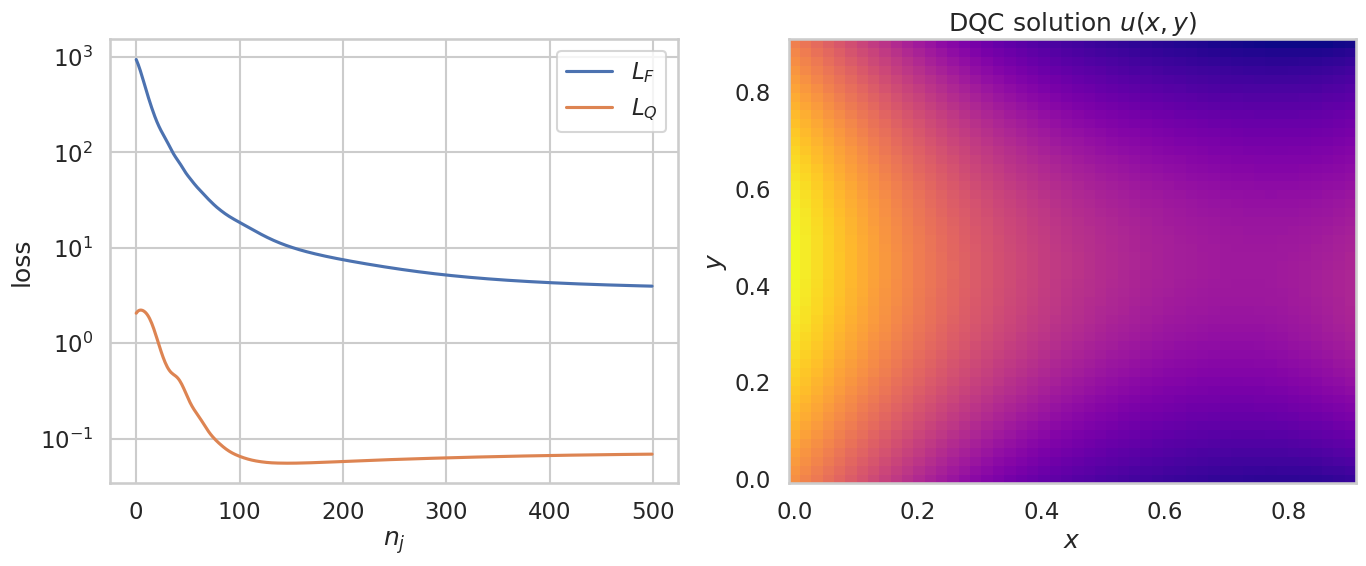

In [ ]:
# N = 6, D = [5, 1], epochs = 500, mode = pinned, wgt=1e3, score = 0.069, time = 21m

n_qubits = 6
depth = [5, 1]
n_epochs = 500
mode = 'pinned'
boundary_loss_weight = 1e2
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);

diff_loss = 2.454e+03, wgtd_bdry_loss = 1.626e+04, score = 1.395e+00
lr: 1.000e-02

diff_loss = 2.365e+03, wgtd_bdry_loss = 1.499e+04, score = 1.204e+00
lr: 1.000e-02

diff_loss = 2.272e+03, wgtd_bdry_loss = 1.375e+04, score = 1.026e+00
lr: 1.000e-02

diff_loss = 2.178e+03, wgtd_bdry_loss = 1.254e+04, score = 8.610e-01
lr: 1.000e-02

diff_loss = 2.083e+03, wgtd_bdry_loss = 1.139e+04, score = 7.113e-01
lr: 1.000e-02

diff_loss = 1.988e+03, wgtd_bdry_loss = 1.030e+04, score = 5.774e-01
lr: 1.000e-02

diff_loss = 1.895e+03, wgtd_bdry_loss = 9.272e+03, score = 4.601e-01
lr: 1.000e-02

diff_loss = 1.805e+03, wgtd_bdry_loss = 8.315e+03, score = 3.599e-01
lr: 1.000e-02

diff_loss = 1.721e+03, wgtd_bdry_loss = 7.432e+03, score = 2.774e-01
lr: 1.000e-02

diff_loss = 1.642e+03, wgtd_bdry_loss = 6.628e+03, score = 2.126e-01
lr: 1.000e-02

diff_loss = 1.570e+03, wgtd_bdry_loss = 5.906e+03, score = 1.655e-01
lr: 1.000e-02

diff_loss = 1.505e+03, wgtd_bdry_loss = 5.268e+03, score = 1.353e-01
lr: 1.0

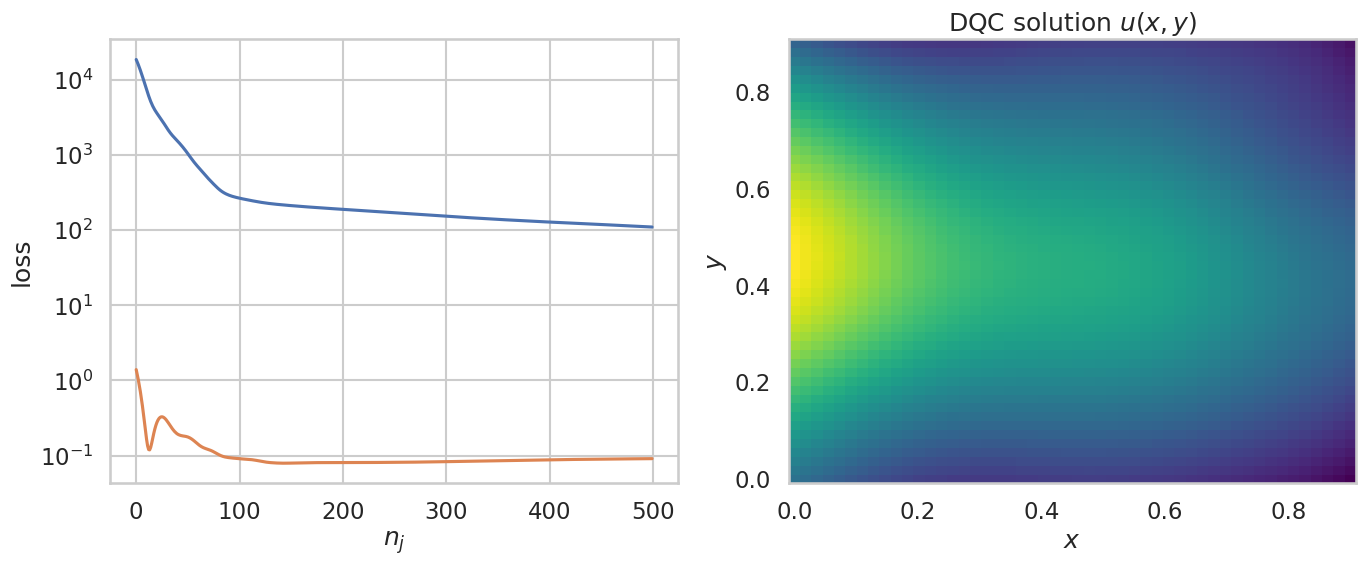

In [33]:
# N = 8, D = [5, 1], epochs = 500, mode = pinned, wgt = 1e3 score = 0.091, time = 112m

n_qubits = 8
depth = [5, 1]
n_epochs = 500
mode = 'pinned'
boundary_loss_weight = 1e3
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
lr = 0.01

model, *extra = get_qnn_model(n_qubits=n_qubits, depth=depth, cost_obs=cost_obs,)
loss_fn = create_loss_fn(model=model, mode=mode, boundary_loss_weight=boundary_loss_weight,)
loss_hist, score_hist = train_model(model=model, n_epochs=n_epochs, lr=lr, loss_fn=loss_fn)

# Final loss
if mode == 'hc':
    f_xy = hc_trial_fn(model(test_inputs)).detach().detach()
if mode == 'pinned':
     f_xy = (model(test_inputs)).detach()
u_xy = solution
score = torch.nn.MSELoss()(u_xy, f_xy).item()
print(f"score:", score)

plot_result((loss_hist, score_hist), f_xy);